In [1]:
# %load defaults.ipy
from numpy import *
import numpy as np
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 600
%matplotlib inline

import matplotlib.pyplot as plt

import collections
import sys
import os
import os.path
sys.path.append('../python')

import latex_plots
import plot_info
from plot_info import showAndSave
import netCDF4
from IPython.core.display import display, HTML
import matplotlib2tikz
import copy
import re
import json
import traceback
with open('structure_function_configs.json') as f:
    configurations = json.load(f)

def for_each_config(f):
    oldPrefix = copy.deepcopy(showAndSave.prefix)
    for conf in configurations.keys():
        
        plot_info.console_log(conf)
        headline(configurations[conf]['name'])
        showAndSave.prefix = oldPrefix + conf
        try:
            f(configurations[conf])
        except Exception as e:
            message = "Skipping {fname} on {conf} ({confname})\n\tReason: {reason}\nTraceback: {traceback}".format(fname=str(f),
                                                                                                       conf=conf, 
                                                                                                       confname=configurations[conf]['name'],
                                                                                                       reason=str(e),
                                                                                                     traceback=traceback.format_exc())
            plot_info.console_log(message)
            print(message)
    showAndSave.prefix=oldPrefix

plot_info.set_notebook_name("structure_postprocess.ipynb")

In [2]:
def headline(text):
    display(HTML("<h1>%s</h1>"%text))
def h2(text):
    display(HTML("<h2>%s</h2>"%text))
def h3(text):
    display(HTML("<h3>%s</h3>"%text))
def h4(text):
    display(HTML("<h4>%s</h4>"%text))
def h5(text):
    display(HTML("<h4>%s</h4>"%text))

In [3]:
def readnetcdf4(filename, variable):
    
    with netCDF4.Dataset(filename) as f:
        return f.variables[variable][:,0,0]

    
def get_number_of_samples(filename):
    max_sample = 0
    with netCDF4.Dataset(filename) as f:
        for v in f.variables.keys():
            match = re.search(r'sample_(\d+)_', v)
            if match:
                sample = int(match.group(1))
                max_sample = max(sample, max_sample)
    return max_sample+1


def upscale(d, r):

    while d.shape[0] < r:
       
        d = repeat(d,2,0)
    return d

def plotscalings_perturbation(d,pert, title,plot_nonlog=True,name=''):
    N = len(d)
    H = linspace(0, 64./2048,N)
   
    poly = polyfit(log(H[1:]),log(d[1:]),1)
  
  
        
    fig = plt.figure(0,figsize=2*plt.figaspect(0.9))
    plt.title(title)
    ax = plt.gca()
    ax.loglog(H[1:],d[1:],label='%s $\\epsilon=%.4f$'%(name, pert))
    ax.loglog(H[1:], exp(poly[1])*H[1:]**(poly[0]), '--',label='$\\mathcal{O}(h^{%.2f})$' % poly[0])
    box = ax.get_position()
    #ax.set_position([box.x0, box.y0 + box.height * 0.1,
    #                 box.width, box.height * 0.9])
    #
    ## Put a legend below current axis
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
    #      fancybox=True, shadow=True, ncol=5)
    ax.legend(loc='center right', bbox_to_anchor=(1, 0.5))
    ax.grid('on')



def plotscalings(d,r,title,plot_nonlog=True):
    N = len(d)
    H = linspace(0, 64./2048,N)
   
    poly = polyfit(log(H[1:]),log(d[1:]),1)
    if plot_nonlog:
        fig = plt.figure(0, figsize=2*plt.figaspect(0.5))
        fig.suptitle(title)
        ax = fig.add_subplot(1,2,1)
        
        ax.plot(H,d,label='r=%d'%r)
        ax.plot(H, exp(poly[1])*H**(poly[0]), '--',label='$\\mathcal{O}(h^{%.2f})$' % poly[0])
        ax.grid('on')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,
                         box.width, box.height * 0.9])
        
        # Put a legend below current axis
        #ax.legend(pos='upper center', bbox_to_anchor=(0.5, -0.05),
        #     fancybox=True, shadow=True, ncol=5)
        
        ax.legend(bbox_to_anchor=(0.5, -0.05),
             fancybox=True, shadow=True, ncol=5)
        
    
          

        ax = fig.add_subplot(1,2,2)
    else:
        
        fig = plt.figure(0)#,figsize=2*plt.figaspect(0.9))
        plt.title(title)
        ax = plt.gca()
    p = ax.loglog(H[1:],d[1:],label='$N=%d$'%r)
    ax.loglog(H[1:], exp(poly[1])*H[1:]**(poly[0]), '--',
              label='$\\mathcal{O}(r^{%.2f})$' % poly[0],
             color=p[0].get_color(), basex=2, basey=2)
    box = ax.get_position()
    #ax.set_position([box.x0, box.y0 + box.height * 0.1,
    #                 box.width, box.height * 0.9])
    #
    ## Put a legend below current axis
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
    #      fancybox=True, shadow=True, ncol=5)
    
    print(f'structure["{title}"][{r}] = {repr(d)}')
    plot_info.legendLeft()
    ax.grid('on')




def getlineintegral(filename, variable,resolution):
    d = readnetcdf4(filename, variable)
    dx = 1.0/resolution
    
    for h in range(1,len(d)):
        d[h] += d[h-1]
    for h in range(1,len(d)):
        d[h] /=(2*h+1)**3
        
    #if 'cuda' not in filename and resolution < 256:
    #    d /= resolution**3
        
    return d
    

64
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=1$"][64] = array([0.        , 0.05719022])
128
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=1$"][128] = array([0.        , 0.05687897, 0.12760359, 0.18750147])
256
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=1$"][256] = array([0.        , 0.0509962 , 0.11382667, 0.16649465, 0.21286676,
       0.25440397, 0.2919308 , 0.32603094])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


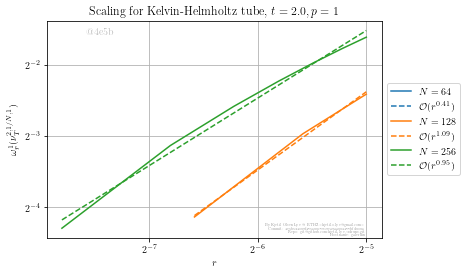

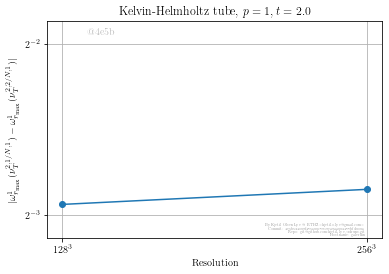

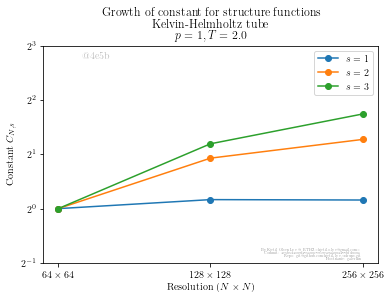

64
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=2$"][64] = array([0.        , 0.08970284])
128
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=2$"][128] = array([0.        , 0.0808601 , 0.14435258, 0.19411973])
256
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=2$"][256] = array([0.        , 0.06888961, 0.12363281, 0.16655334, 0.20271744,
       0.23387337, 0.26106581, 0.28503989])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


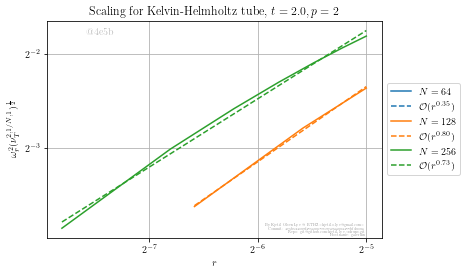

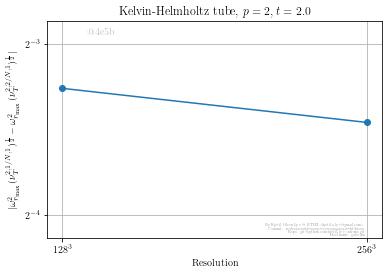

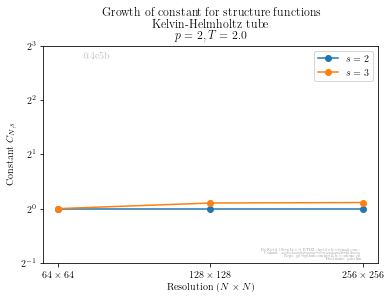

64
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=3$"][64] = array([0.        , 0.13403714])
128
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=3$"][128] = array([0.        , 0.11862574, 0.19007291, 0.24313713])
256
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=3$"][256] = array([0.        , 0.09808484, 0.15917257, 0.20512604, 0.24256939,
       0.27394335, 0.30070239, 0.32385035])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


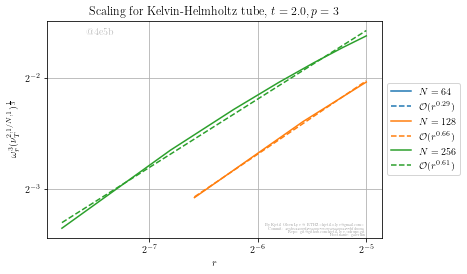

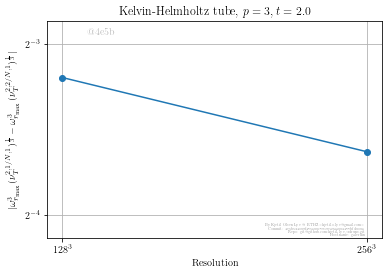

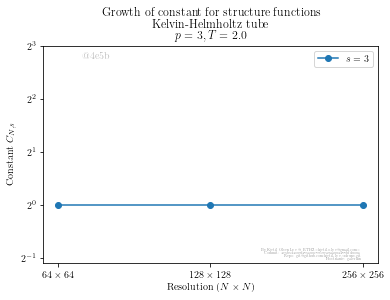

512
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=1,\varepsilon=0.1$"][64] = array([0.        , 0.00452638, 0.01193717, 0.01831922, 0.02411193,
       0.02946828, 0.03445663, 0.03911518, 0.04360583, 0.04806121,
       0.05252028, 0.0569878 , 0.06145632, 0.06591469, 0.07035147,
       0.0747562 ])
512
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=1,\varepsilon=0.1$"][128] = array([0.        , 0.0085753 , 0.0209745 , 0.03062714, 0.03905764,
       0.0471504 , 0.05513126, 0.06295769, 0.07067909, 0.07835185,
       0.08595207, 0.09344992, 0.10085603, 0.10818876, 0.11543929,
       0.12259713])
512
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=1,\varepsilon=0.1$"][256] = array([0.        , 0.01910182, 0.04322226, 0.06294413, 0.08121821,
       0.09849996, 0.11490264, 0.13052006, 0.14538191, 0.1595446 ,
       0.17303779, 0.18590719, 0.19818476, 0.20991027, 0.22111543,
       0.2318352 ])
512
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=1,\varepsilon=0.1$

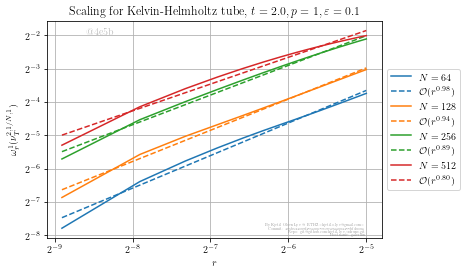

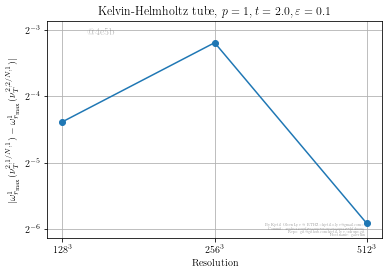

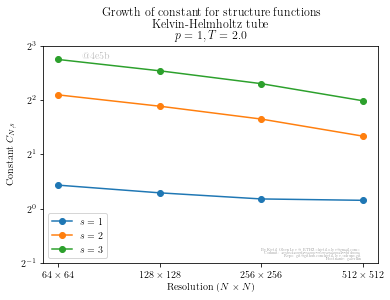

512
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=2,\varepsilon=0.1$"][64] = array([0.        , 0.02430547, 0.04031586, 0.05060407, 0.05875531,
       0.06571147, 0.0718727 , 0.07745226, 0.08332917, 0.08975667,
       0.09643926, 0.10318416, 0.10987437, 0.11644227, 0.12285094,
       0.12908218])
512
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=2,\varepsilon=0.1$"][128] = array([0.        , 0.02660396, 0.0436958 , 0.05461562, 0.06522287,
       0.07612689, 0.08675285, 0.09679471, 0.10664178, 0.11640918,
       0.12589994, 0.13502232, 0.14391113, 0.15263789, 0.16114056,
       0.16938636])
512
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=2,\varepsilon=0.1$"][256] = array([0.        , 0.03621023, 0.06412269, 0.08584033, 0.10598699,
       0.12460504, 0.14189198, 0.15796622, 0.1729189 , 0.18686106,
       0.19987035, 0.21203782, 0.22343186, 0.2341261 , 0.24417972,
       0.25365241])
512
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=2,\varepsilon=0.1$

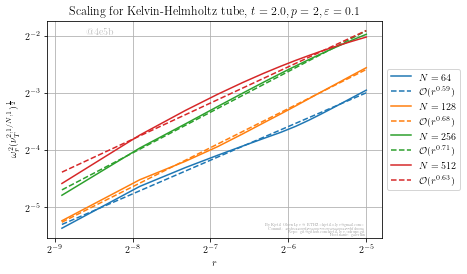

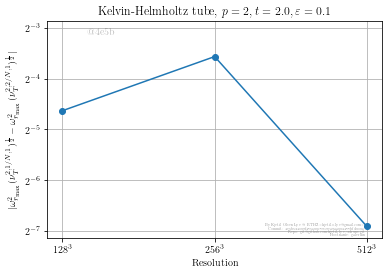

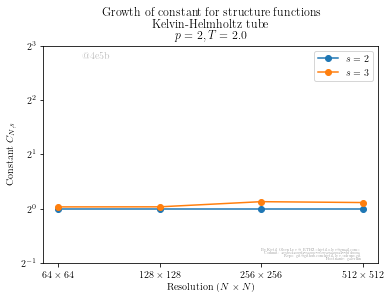

512
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=3,\varepsilon=0.1$"][64] = array([0.        , 0.05557318, 0.07862142, 0.09203311, 0.10221734,
       0.11070097, 0.11810396, 0.12474604, 0.13230719, 0.14103318,
       0.15015002, 0.15922897, 0.16805781, 0.17654365, 0.18465585,
       0.1923951 ])
512
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=3,\varepsilon=0.1$"][128] = array([0.        , 0.0527915 , 0.07574489, 0.08955725, 0.10423497,
       0.11935613, 0.13353539, 0.14639111, 0.15889084, 0.17119408,
       0.18290833, 0.1939105 , 0.20452179, 0.214876  , 0.22485191,
       0.23440012])
512
structure["Scaling for Kelvin-Helmholtz tube, $t=2.0,p=3,\varepsilon=0.1$"][256] = array([0.        , 0.05721156, 0.09320104, 0.11923957, 0.14345375,
       0.16521007, 0.18509324, 0.20325077, 0.21990705, 0.23523152,
       0.24936658, 0.26244695, 0.27457981, 0.28586942, 0.29640111,
       0.30625601])
512
Skipping <function convergence_structure_functions at 0x7fe0346ed170> on 

64
structure["Scaling for Kelvin-Helmholtz tube (cuda), $t=2.0,p=1$"][64] = array([0.        , 0.05719022])
128
structure["Scaling for Kelvin-Helmholtz tube (cuda), $t=2.0,p=1$"][128] = array([0.        , 0.05687897, 0.12760359, 0.18750147])
256
structure["Scaling for Kelvin-Helmholtz tube (cuda), $t=2.0,p=1$"][256] = array([0.        , 0.0509962 , 0.11382667, 0.16649465, 0.21286676,
       0.25440397, 0.2919308 , 0.32603094])
512
structure["Scaling for Kelvin-Helmholtz tube (cuda), $t=2.0,p=1$"][512] = array([0.        , 0.03860268, 0.08648025, 0.12683473, 0.16252989,
       0.19461119, 0.22366355, 0.25010889, 0.27428648, 0.29648072,
       0.31693382, 0.33585337, 0.35341791, 0.3697814 , 0.38507689,
       0.39941972])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


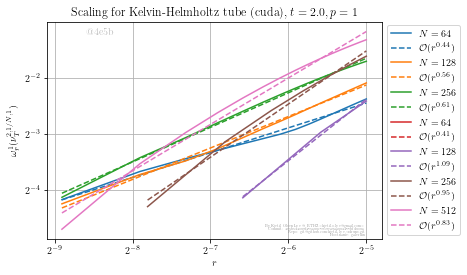

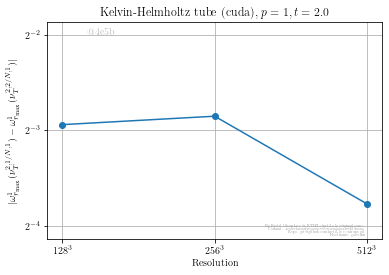

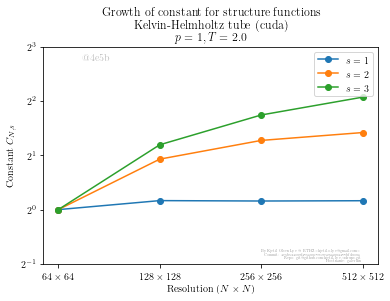

64
structure["Scaling for Kelvin-Helmholtz tube (cuda), $t=2.0,p=2$"][64] = array([0.        , 0.08970284])
128
structure["Scaling for Kelvin-Helmholtz tube (cuda), $t=2.0,p=2$"][128] = array([0.        , 0.0808601 , 0.14435258, 0.19411973])
256
structure["Scaling for Kelvin-Helmholtz tube (cuda), $t=2.0,p=2$"][256] = array([0.        , 0.06888961, 0.12363281, 0.16655334, 0.20271744,
       0.23387337, 0.26106581, 0.28503989])
512
structure["Scaling for Kelvin-Helmholtz tube (cuda), $t=2.0,p=2$"][512] = array([0.        , 0.05121353, 0.09283054, 0.12588546, 0.15401465,
       0.17841691, 0.19981661, 0.21874689, 0.2356255 , 0.25078695,
       0.26450145, 0.27698855, 0.28842755, 0.29896567, 0.30872456,
       0.31780533])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


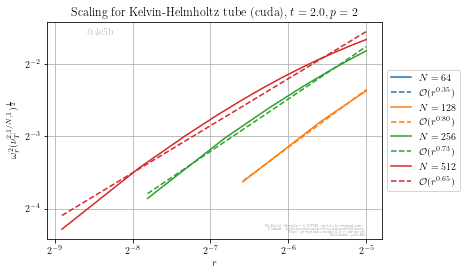

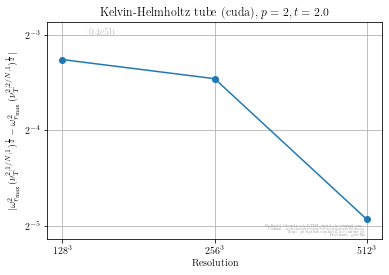

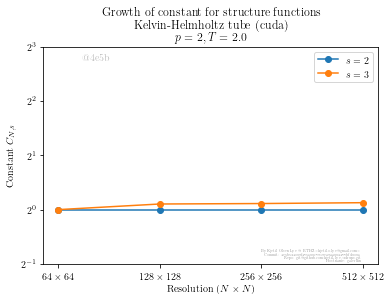

64
structure["Scaling for Kelvin-Helmholtz tube (cuda), $t=2.0,p=3$"][64] = array([0.        , 0.13403714])
128
structure["Scaling for Kelvin-Helmholtz tube (cuda), $t=2.0,p=3$"][128] = array([0.        , 0.11862574, 0.19007291, 0.24313713])
256
structure["Scaling for Kelvin-Helmholtz tube (cuda), $t=2.0,p=3$"][256] = array([0.        , 0.09808484, 0.15917257, 0.20512604, 0.24256939,
       0.27394335, 0.30070239, 0.32385035])
512
structure["Scaling for Kelvin-Helmholtz tube (cuda), $t=2.0,p=3$"][512] = array([0.        , 0.07317448, 0.12030524, 0.15636019, 0.18605793,
       0.21110546, 0.23255035, 0.25113976, 0.26743561, 0.28186988,
       0.29477853, 0.30642502, 0.31701763, 0.32672238, 0.3356727 ,
       0.34397676])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


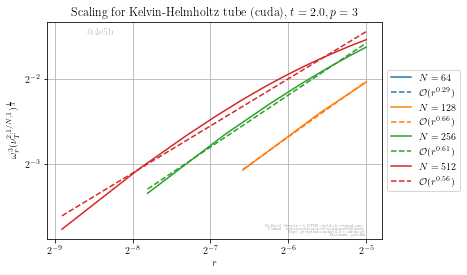

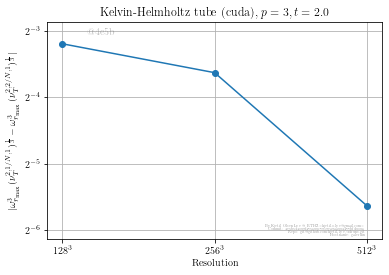

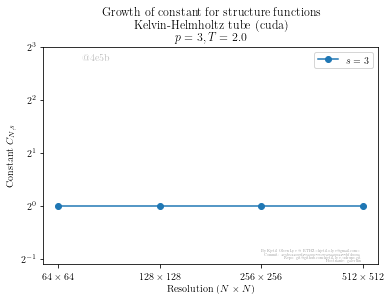

64
structure["Scaling for Brownian motion, $t=0.0,p=1$"][64] = array([0.        , 0.87315916])
128
structure["Scaling for Brownian motion, $t=0.0,p=1$"][128] = array([0.       , 0.6403194, 1.0786142, 1.3376284])
256
structure["Scaling for Brownian motion, $t=0.0,p=1$"][256] = array([0.        , 0.46171156, 0.78395961, 0.97961483, 1.12517101,
       1.24350436, 1.3445179 , 1.43333456])
512
structure["Scaling for Brownian motion, $t=0.0,p=1$"][512] = array([0.        , 0.33006764, 0.56320173, 0.70709856, 0.81583711,
       0.90554584, 0.98318119, 1.05232972, 1.1151134 , 1.17284952,
       1.22638252, 1.27634983, 1.32329509, 1.36763116, 1.40964378,
       1.44957835])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


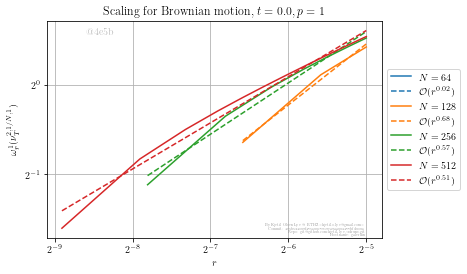

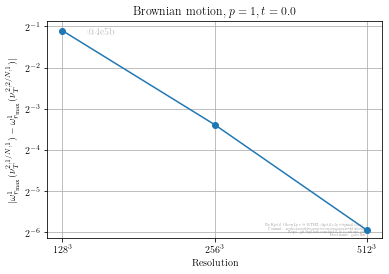

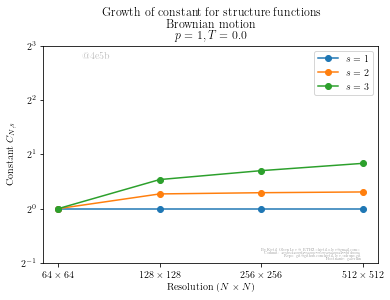

64
structure["Scaling for Brownian motion, $t=0.2,p=1$"][64] = array([0.        , 0.50379956])
128
structure["Scaling for Brownian motion, $t=0.2,p=1$"][128] = array([0.        , 0.35929511, 0.80057313, 1.16175794])
256
structure["Scaling for Brownian motion, $t=0.2,p=1$"][256] = array([0.        , 0.25223731, 0.56754667, 0.83311491, 1.06606095,
       1.27251622, 1.45643291, 1.6211658 ])
512
structure["Scaling for Brownian motion, $t=0.2,p=1$"][512] = array([0.        , 0.17604168, 0.39853317, 0.58940696, 0.7604155 ,
       0.91527671, 1.05605045, 1.18443094, 1.30196942, 1.41007645,
       1.50999969, 1.60281672, 1.68944347, 1.77065145, 1.84708822,
       1.91929756])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


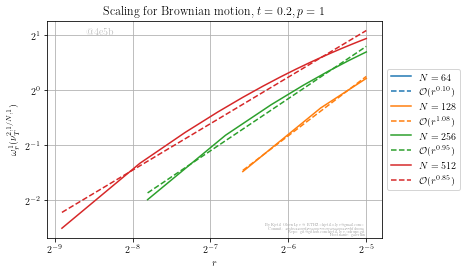

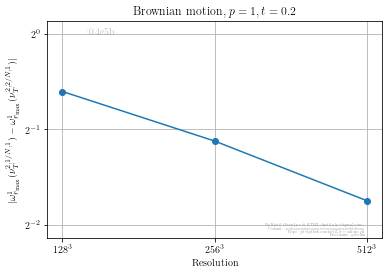

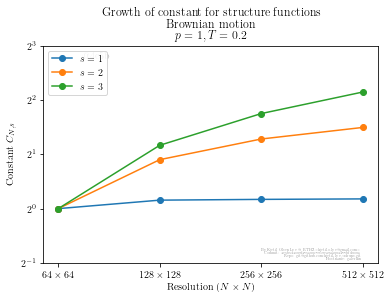

64
structure["Scaling for Brownian motion, $t=0.0,p=2$"][64] = array([0.        , 0.82517104])
128
structure["Scaling for Brownian motion, $t=0.0,p=2$"][128] = array([0.        , 0.60182861, 0.84997779, 0.99838641])
256
structure["Scaling for Brownian motion, $t=0.0,p=2$"][256] = array([0.        , 0.43293978, 0.61653955, 0.72960441, 0.81682967,
       0.88964503, 0.95319006, 1.01001767])
512
structure["Scaling for Brownian motion, $t=0.0,p=2$"][512] = array([0.        , 0.30916057, 0.44247894, 0.52602361, 0.59146216,
       0.64685619, 0.69581409, 0.74011515, 0.78071225, 0.81825628,
       0.85327118, 0.88616342, 0.91724055, 0.94672989, 0.97479944,
       1.00157847])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


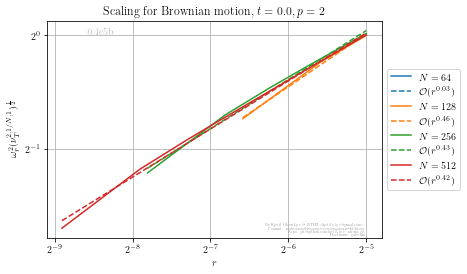

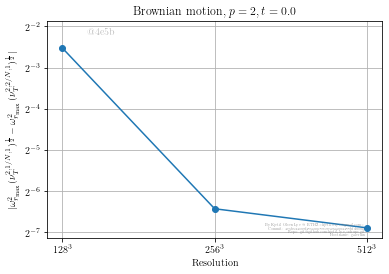

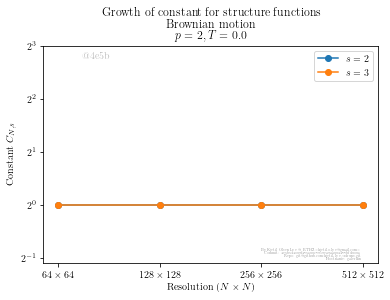

64
structure["Scaling for Brownian motion, $t=0.2,p=2$"][64] = array([0.        , 0.44894923])
128
structure["Scaling for Brownian motion, $t=0.2,p=2$"][128] = array([0.        , 0.32551897, 0.5984879 , 0.81543445])
256
structure["Scaling for Brownian motion, $t=0.2,p=2$"][256] = array([0.        , 0.23326306, 0.43300698, 0.59652731, 0.73831764,
       0.86265701, 0.97245489, 1.07015711])
512
structure["Scaling for Brownian motion, $t=0.2,p=2$"][512] = array([0.        , 0.16696064, 0.31173135, 0.43245586, 0.53928464,
       0.63485736, 0.72080769, 0.79851531, 0.86919192, 0.93388127,
       0.99346297, 1.04866761, 1.10009744, 1.14824792, 1.1935275 ,
       1.23627442])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


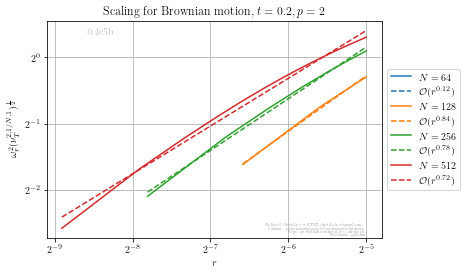

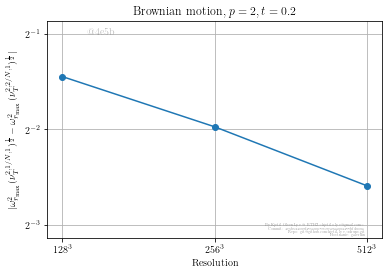

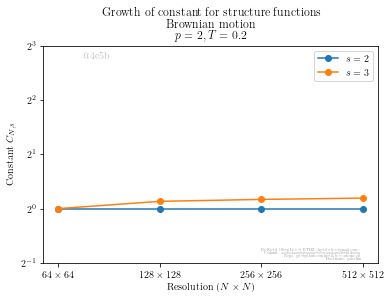

64
structure["Scaling for Brownian motion, $t=0.0,p=3$"][64] = array([0.        , 0.89382787])
128
structure["Scaling for Brownian motion, $t=0.0,p=3$"][128] = array([0.        , 0.65037967, 0.86608818, 1.00000388])
256
structure["Scaling for Brownian motion, $t=0.0,p=3$"][256] = array([0.        , 0.46739037, 0.62740434, 0.72963316, 0.81028301,
       0.87856715, 0.9389164 , 0.99340769])
512
structure["Scaling for Brownian motion, $t=0.0,p=3$"][512] = array([0.        , 0.33360018, 0.44997523, 0.5255945 , 0.58611534,
       0.6380341 , 0.68445796, 0.72682779, 0.76575982, 0.80178537,
       0.83546478, 0.86722803, 0.89734245, 0.92600042, 0.95335703,
       0.97951203])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


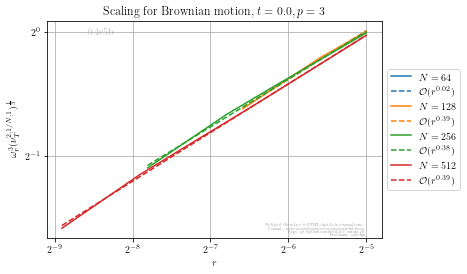

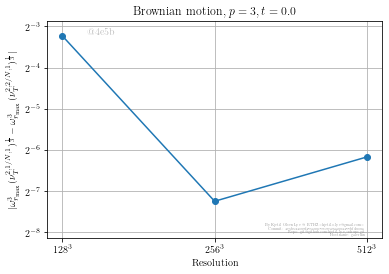

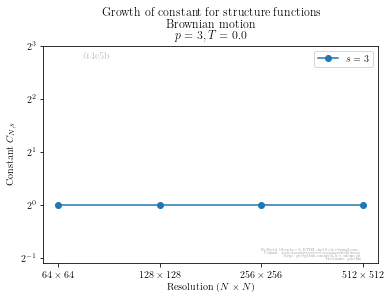

64
structure["Scaling for Brownian motion, $t=0.2,p=3$"][64] = array([0.        , 0.51447259])
128
structure["Scaling for Brownian motion, $t=0.2,p=3$"][128] = array([0.        , 0.38311734, 0.65136629, 0.86261036])
256
structure["Scaling for Brownian motion, $t=0.2,p=3$"][256] = array([0.        , 0.28505126, 0.4875651 , 0.65074109, 0.79008091,
       0.91076814, 1.01640653, 1.10985544])
512
structure["Scaling for Brownian motion, $t=0.2,p=3$"][512] = array([0.        , 0.21512083, 0.36820216, 0.49256895, 0.60019373,
       0.69480535, 0.77881292, 0.85409045, 0.92214171, 0.98417286,
       1.04114839, 1.09383945, 1.14286451, 1.18872244, 1.23181864,
       1.27248541])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


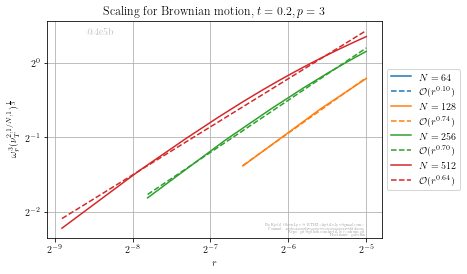

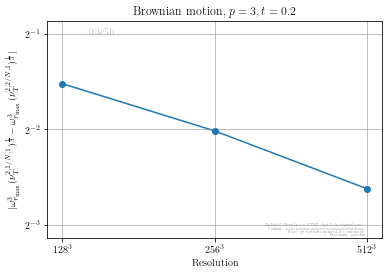

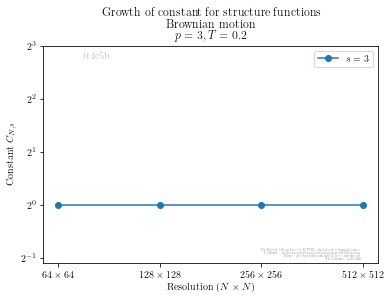

64
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.0,p=1$"][64] = array([0.        , 0.26570854])
128
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.0,p=1$"][128] = array([0.        , 0.16856432, 0.30751695, 0.40228203])
256
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.0,p=1$"][256] = array([0.        , 0.10454814, 0.19387626, 0.25708654, 0.30904085,
       0.35435349, 0.39510359, 0.4324146 ])
512
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.0,p=1$"][512] = array([0.        , 0.06397658, 0.12001967, 0.16066071, 0.19473194,
       0.22496053, 0.2525649 , 0.27819643, 0.3022528 , 0.32499366,
       0.34659688, 0.36720286, 0.38693037, 0.40587291, 0.42410113,
       0.44167666])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


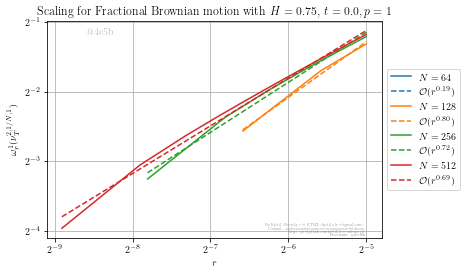

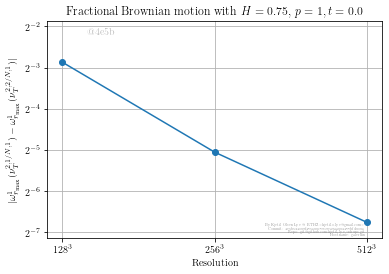

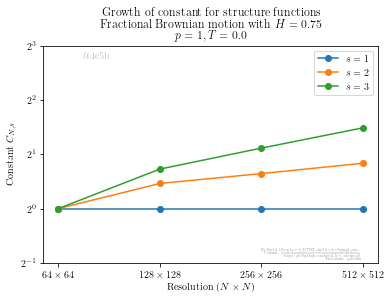

64
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.2,p=1$"][64] = array([0.        , 0.21238341])
128
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.2,p=1$"][128] = array([0.        , 0.13697078, 0.30907788, 0.45492093])
256
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.2,p=1$"][256] = array([0.        , 0.08578913, 0.19520137, 0.29024535, 0.37663713,
       0.45609236, 0.52947227, 0.59745266])
512
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.2,p=1$"][512] = array([0.        , 0.05275324, 0.12062881, 0.18050255, 0.23593135,
       0.2879113 , 0.33684623, 0.3830012 , 0.42661367, 0.46791416,
       0.50712333, 0.5444456 , 0.5800651 , 0.61414463, 0.64682662,
       0.6782353 ])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


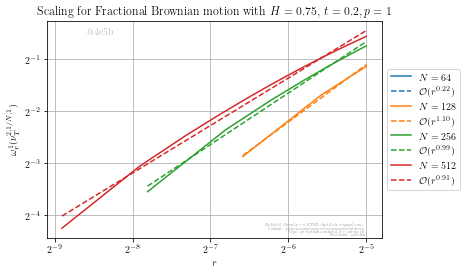

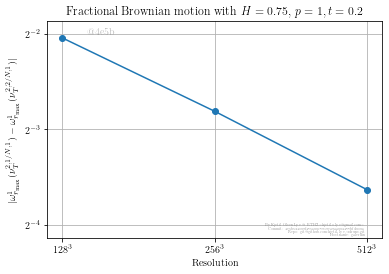

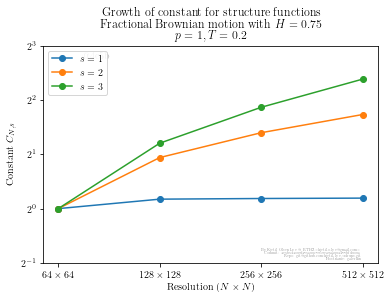

64
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.0,p=2$"][64] = array([0.        , 0.26221844])
128
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.0,p=2$"][128] = array([0.        , 0.16543043, 0.25317089, 0.314058  ])
256
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.0,p=2$"][256] = array([0.        , 0.10237208, 0.15923354, 0.20014828, 0.23471416,
       0.26543208, 0.29347304, 0.31942188])
512
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.0,p=2$"][512] = array([0.        , 0.06258103, 0.09845085, 0.12488066, 0.1476176 ,
       0.16814007, 0.18712999, 0.20492418, 0.22170995, 0.23763038,
       0.25280953, 0.26734509, 0.28131058, 0.29476082, 0.30773743,
       0.32027339])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


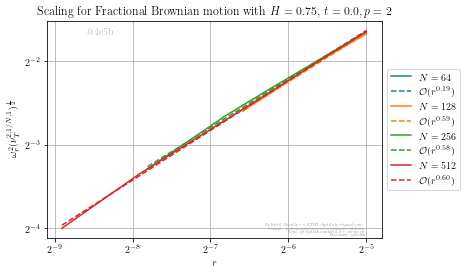

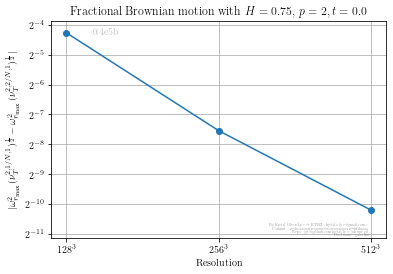

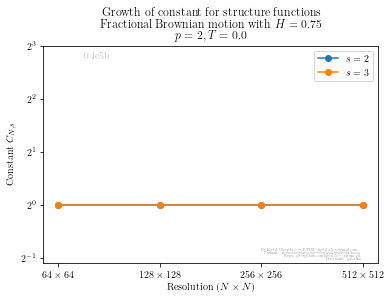

64
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.2,p=2$"][64] = array([0.        , 0.18487238])
128
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.2,p=2$"][128] = array([0.        , 0.1192988 , 0.22315386, 0.30989982])
256
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.2,p=2$"][256] = array([0.        , 0.0747953 , 0.14117479, 0.19816841, 0.25008478,
       0.29782695, 0.3418692 , 0.38262469])
512
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.2,p=2$"][512] = array([0.        , 0.04608007, 0.08745744, 0.12360903, 0.15719446,
       0.18870978, 0.21835077, 0.24626862, 0.2726135 , 0.29753536,
       0.32117728, 0.34367029, 0.36513093, 0.38566116, 0.40534949,
       0.42427263])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


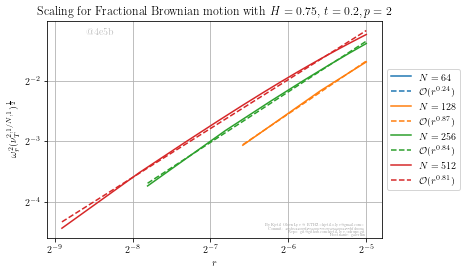

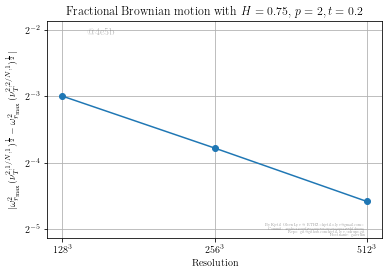

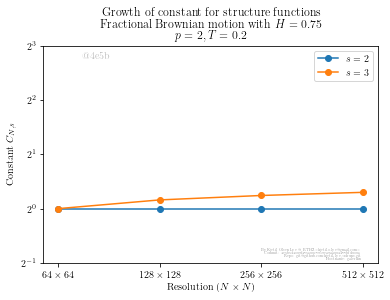

64
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.0,p=3$"][64] = array([0.        , 0.28939734])
128
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.0,p=3$"][128] = array([0.        , 0.18210646, 0.26286027, 0.3209417 ])
256
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.0,p=3$"][256] = array([0.        , 0.11254789, 0.16499822, 0.20401802, 0.23752758,
       0.26762315, 0.29534186, 0.32114494])
512
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.0,p=3$"][512] = array([0.        , 0.06875575, 0.10189335, 0.12709342, 0.14910519,
       0.1691614 , 0.18786056, 0.20546664, 0.22209871, 0.23788534,
       0.25296701, 0.26744877, 0.28139697, 0.29485774, 0.30786613,
       0.32044546])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


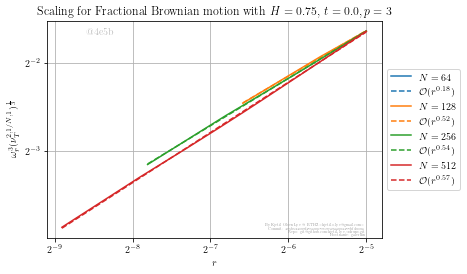

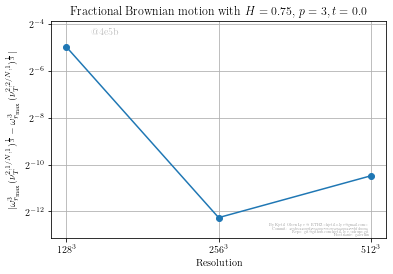

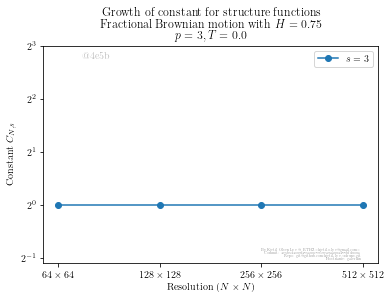

64
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.2,p=3$"][64] = array([0.        , 0.20535632])
128
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.2,p=3$"][128] = array([0.        , 0.13294006, 0.23182885, 0.31518084])
256
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.2,p=3$"][256] = array([0.        , 0.08364056, 0.1472556 , 0.20242117, 0.25276221,
       0.29900319, 0.3415952 , 0.3809622 ])
512
structure["Scaling for Fractional Brownian motion with $H=0.75$, $t=0.2,p=3$"][512] = array([0.        , 0.05174881, 0.09165777, 0.12690888, 0.1597306 ,
       0.19049394, 0.21937248, 0.24652335, 0.27210777, 0.29628482,
       0.31920351, 0.34099796, 0.36178598, 0.38166966, 0.40073704,
       0.41906408])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


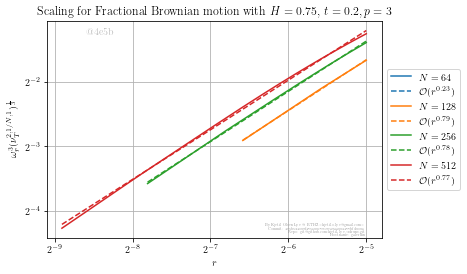

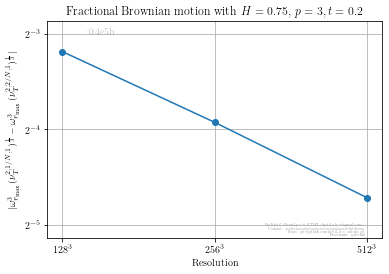

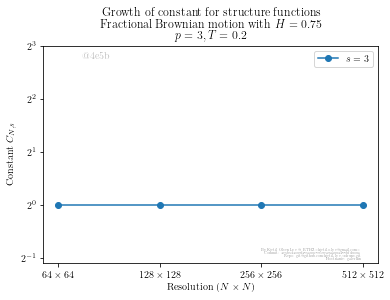

64
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.0,p=1$"][64] = array([0.        , 5.79362617])
128
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.0,p=1$"][128] = array([ 0.        ,  5.60238004,  8.62792612, 10.05604658])
256
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.0,p=1$"][256] = array([ 0.        ,  5.34772449,  8.25214491,  9.63836993, 10.48563271,
       11.07386541, 11.51545728, 11.86458478])
512
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.0,p=1$"][512] = array([ 0.        ,  5.07019561,  7.83592795,  9.16557418,  9.98477625,
       10.55818799, 10.99215823, 11.33802718, 11.6242132 , 11.86734327,
       12.07759346, 12.26189509, 12.42581922, 12.57336345, 12.70706611,
       12.8288931 ])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


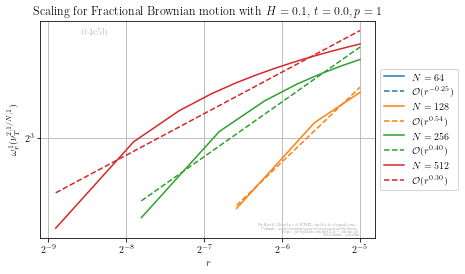

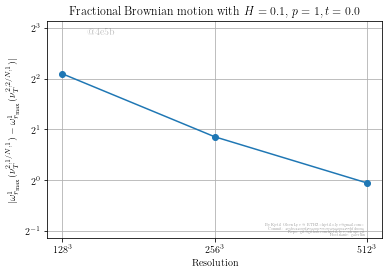

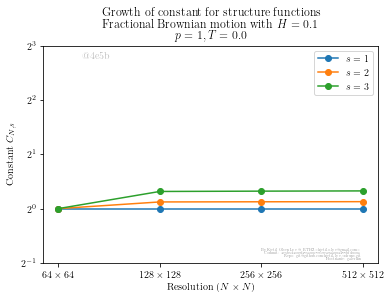

64
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.2,p=1$"][64] = array([0.        , 1.58373056])
128
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.2,p=1$"][128] = array([0.        , 1.26640455, 2.74025368, 3.86256258])
256
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.2,p=1$"][256] = array([0.        , 0.99797566, 2.18551055, 3.11983774, 3.88522349,
       4.52247415, 5.05980711, 5.51859289])
512
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.2,p=1$"][512] = array([0.        , 0.78318782, 1.72733069, 2.48465032, 3.11746851,
       3.65407137, 4.11384794, 4.51184686, 4.85994841, 5.16750555,
       5.44186401, 5.68879909, 5.9128693 , 6.11769418, 6.30616817,
       6.48062399])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


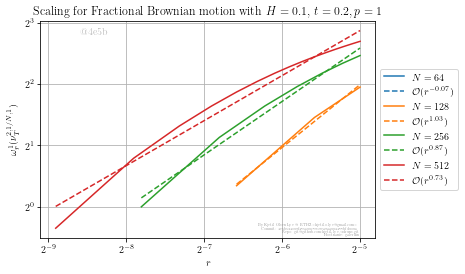

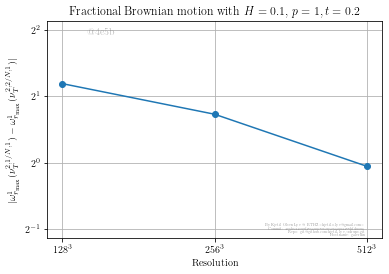

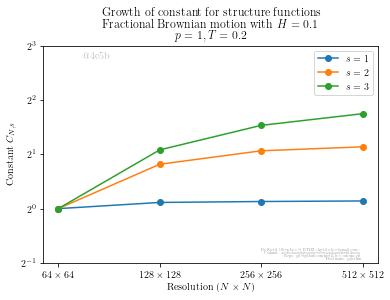

64
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.0,p=2$"][64] = array([0.        , 5.29820082])
128
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.0,p=2$"][128] = array([0.        , 5.10836659, 6.57544144, 7.23911056])
256
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.0,p=2$"][256] = array([0.        , 4.87451992, 6.2933068 , 6.94503598, 7.35127845,
       7.63985729, 7.86126349, 8.03964802])
512
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.0,p=2$"][512] = array([0.        , 4.62652626, 5.98553443, 6.61607462, 7.01300583,
       7.29764371, 7.51803228, 7.6971845 , 7.8478591 , 7.97756939,
       8.0909956 , 8.1913828 , 8.28144951, 8.36314559, 8.43767299,
       8.50596899])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


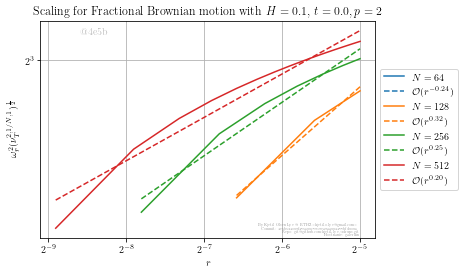

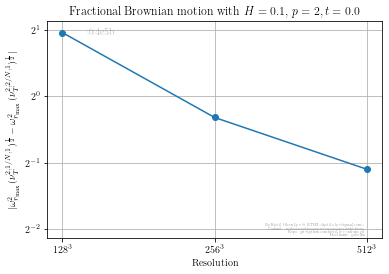

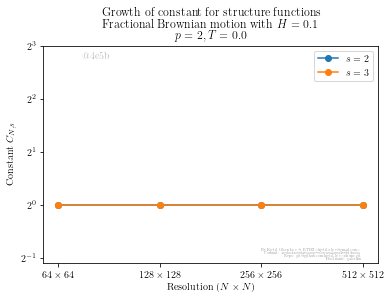

64
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.2,p=2$"][64] = array([0.        , 1.55522135])
128
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.2,p=2$"][128] = array([0.        , 1.29114822, 2.27815371, 2.98486597])
256
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.2,p=2$"][256] = array([0.        , 1.04765293, 1.87129618, 2.48237076, 2.9679339 ,
       3.36360116, 3.69239296, 3.97047576])
512
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.2,p=2$"][512] = array([0.        , 0.83688602, 1.50726256, 2.01634866, 2.42960179,
       2.77259281, 3.06207774, 3.31017163, 3.52580325, 3.71561522,
       3.88460011, 4.03655433, 4.17440055, 4.30041698, 4.4164012 ,
       4.5237882 ])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


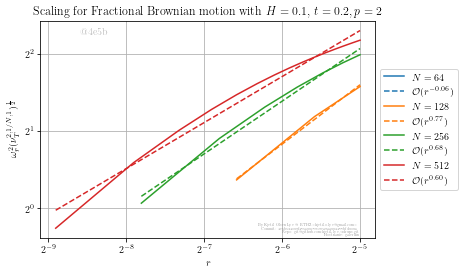

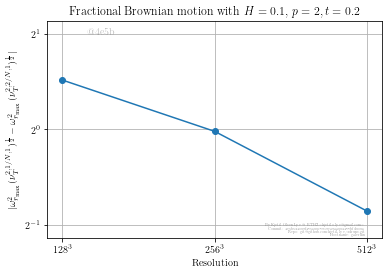

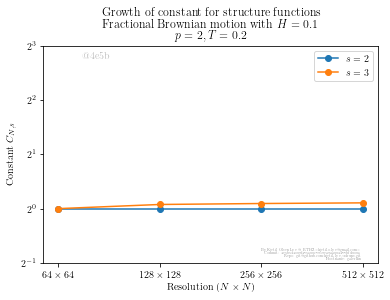

64
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.0,p=3$"][64] = array([0.        , 5.76216152])
128
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.0,p=3$"][128] = array([0.        , 5.57068769, 6.74175883, 7.27397221])
256
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.0,p=3$"][256] = array([0.        , 5.33178348, 6.47381094, 7.00218665, 7.33785291,
       7.57964637, 7.76728714, 7.91974686])
512
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.0,p=3$"][512] = array([0.        , 5.07720066, 6.17889329, 6.69478298, 7.02612438,
       7.26720446, 7.4561068 , 7.61104375, 7.74220711, 7.85567854,
       7.95530226, 8.04374969, 8.12333351, 8.19570214, 8.2618355 ,
       8.32250247])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


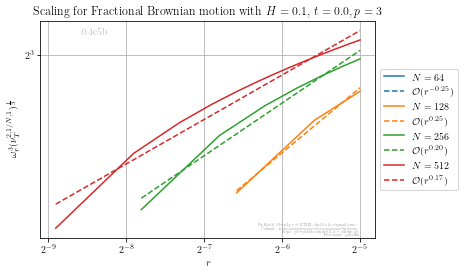

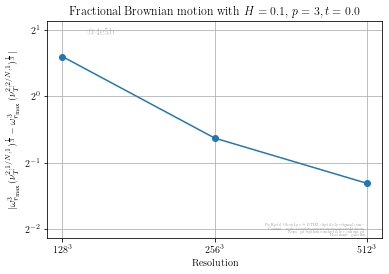

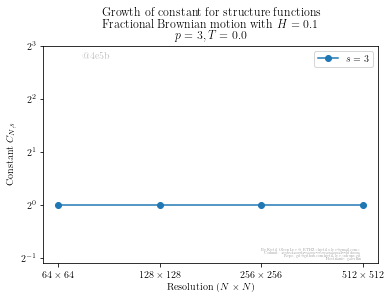

64
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.2,p=3$"][64] = array([0.        , 1.95581438])
128
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.2,p=3$"][128] = array([0.        , 1.70185917, 2.73940633, 3.45341786])
256
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.2,p=3$"][256] = array([0.        , 1.44519921, 2.34612816, 2.98488369, 3.47742422,
       3.87122781, 4.19479915, 4.46670743])
512
structure["Scaling for Fractional Brownian motion with $H=0.1$, $t=0.2,p=3$"][512] = array([0.        , 1.20214067, 1.96182832, 2.51066679, 2.94160904,
       3.29169211, 3.58333231, 3.83137929, 4.04605496, 4.23459732,
       4.40225969, 4.55294079, 4.68959289, 4.81449231, 4.92942281,
       5.03580263])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


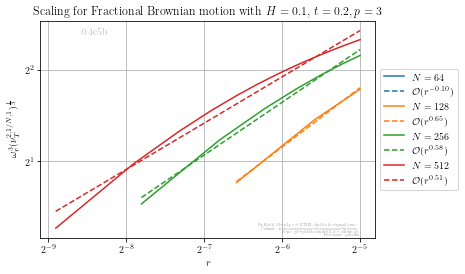

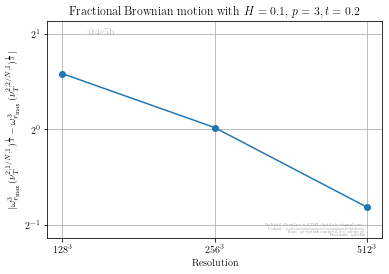

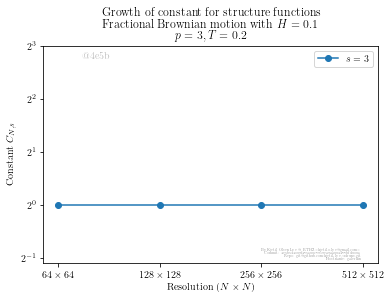

64
structure["Scaling for Brownian motion (single precision), $t=0.2,p=1$"][64] = array([0.       , 0.5057662])
128
structure["Scaling for Brownian motion (single precision), $t=0.2,p=1$"][128] = array([0.        , 0.35899742, 0.79991374, 1.16079165])
256
structure["Scaling for Brownian motion (single precision), $t=0.2,p=1$"][256] = array([0.        , 0.2522313 , 0.56752966, 0.8330927 , 1.06604175,
       1.27251066, 1.45645367, 1.62122717])
512
structure["Scaling for Brownian motion (single precision), $t=0.2,p=1$"][512] = array([0.        , 0.17610126, 0.39866633, 0.58960584, 0.76067642,
       0.91559737, 1.0564293 , 1.18486699, 1.30246217, 1.41062583,
       1.51060599, 1.60348051, 1.69016551, 1.77143267, 1.84792969,
       1.92020044])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


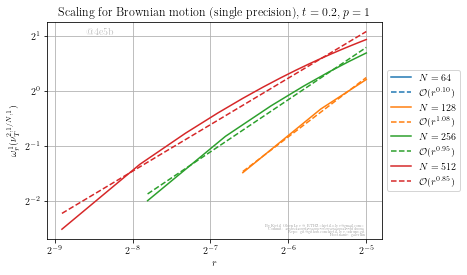

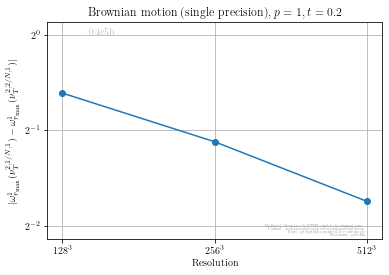

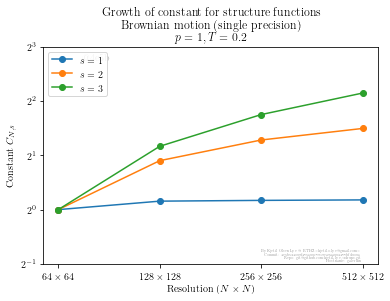

64
structure["Scaling for Brownian motion (single precision), $t=0.2,p=2$"][64] = array([0.        , 0.45204687])
128
structure["Scaling for Brownian motion (single precision), $t=0.2,p=2$"][128] = array([0.        , 0.32526995, 0.5981301 , 0.81497319])
256
structure["Scaling for Brownian motion (single precision), $t=0.2,p=2$"][256] = array([0.        , 0.23326078, 0.43303938, 0.59659449, 0.73842334,
       0.86280697, 0.97265667, 1.07041955])
512
structure["Scaling for Brownian motion (single precision), $t=0.2,p=2$"][512] = array([0.        , 0.16699205, 0.31178067, 0.43252224, 0.53936734,
       0.63495554, 0.72092054, 0.79864215, 0.86933229, 0.93403493,
       0.99362993, 1.04884805, 1.10029167, 1.14845636, 1.1937506 ,
       1.23651264])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


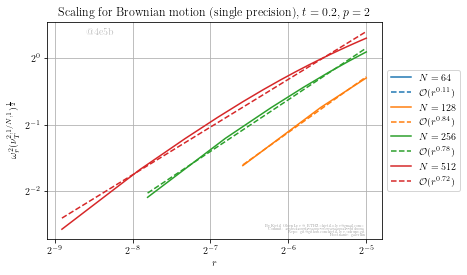

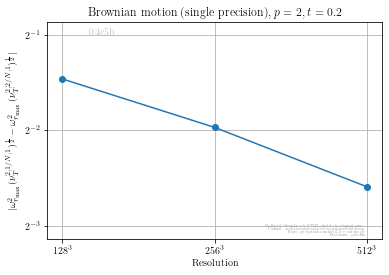

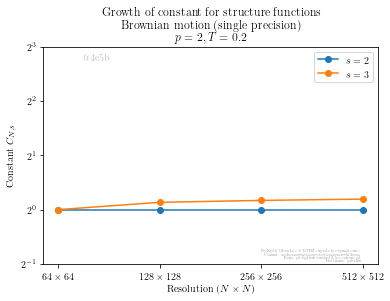

64
structure["Scaling for Brownian motion (single precision), $t=0.2,p=3$"][64] = array([0.        , 0.52012888])
128
structure["Scaling for Brownian motion (single precision), $t=0.2,p=3$"][128] = array([0.        , 0.38265012, 0.65109848, 0.86240712])
256
structure["Scaling for Brownian motion (single precision), $t=0.2,p=3$"][256] = array([0.        , 0.28480804, 0.48742357, 0.65068658, 0.79011404,
       0.91089284, 1.01662979, 1.1101865 ])
512
structure["Scaling for Brownian motion (single precision), $t=0.2,p=3$"][512] = array([0.        , 0.21515255, 0.36820555, 0.49253758, 0.60013044,
       0.69471298, 0.77869328, 0.85394462, 0.92197038, 0.98397656,
       1.04092761, 1.09359474, 1.1425965 , 1.1884318 , 1.23150612,
       1.27215178])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


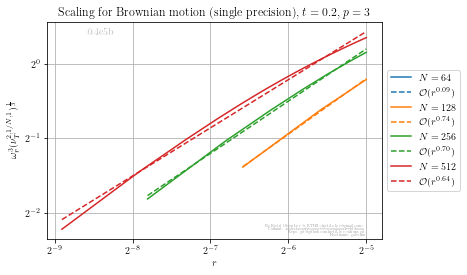

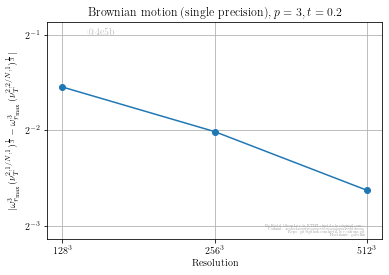

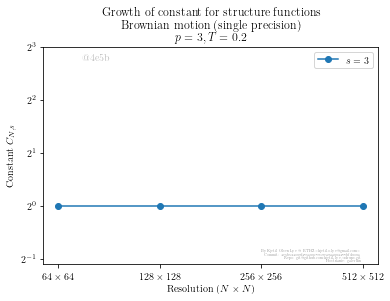

64
structure["Scaling for Fractional Brownian motion with $H=0.75$ (single precision), $t=0.2,p=1$"][64] = array([0.        , 0.21338165])
128
structure["Scaling for Fractional Brownian motion with $H=0.75$ (single precision), $t=0.2,p=1$"][128] = array([0.       , 0.1368042, 0.308708 , 0.4543729])
256
structure["Scaling for Fractional Brownian motion with $H=0.75$ (single precision), $t=0.2,p=1$"][256] = array([0.        , 0.0857929 , 0.1952059 , 0.29025104, 0.37664532,
       0.45610517, 0.52949268, 0.59748448])
512
structure["Scaling for Fractional Brownian motion with $H=0.75$ (single precision), $t=0.2,p=1$"][512] = array([0.        , 0.0527792 , 0.12068597, 0.18058859, 0.23604574,
       0.28805404, 0.33701753, 0.38320141, 0.42684319, 0.46817347,
       0.50741292, 0.54476596, 0.58041674, 0.61452803, 0.64724227,
       0.67868367])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


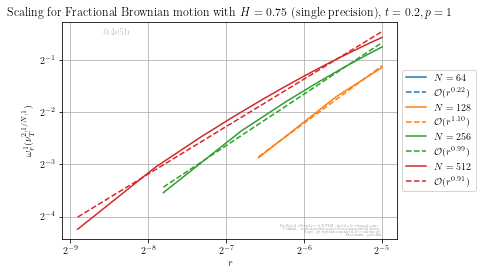

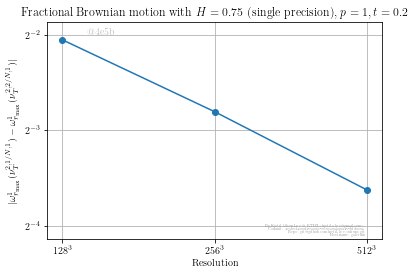

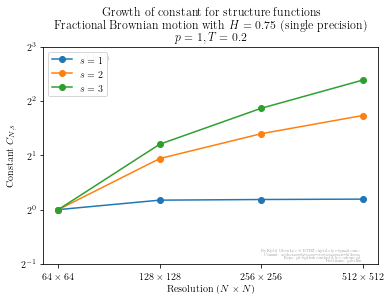

64
structure["Scaling for Fractional Brownian motion with $H=0.75$ (single precision), $t=0.2,p=2$"][64] = array([0.       , 0.1861928])
128
structure["Scaling for Fractional Brownian motion with $H=0.75$ (single precision), $t=0.2,p=2$"][128] = array([0.        , 0.11917267, 0.22294504, 0.3096182 ])
256
structure["Scaling for Fractional Brownian motion with $H=0.75$ (single precision), $t=0.2,p=2$"][256] = array([0.        , 0.07479813, 0.14118262, 0.1981816 , 0.25010477,
       0.29785594, 0.34191006, 0.38268084])
512
structure["Scaling for Fractional Brownian motion with $H=0.75$ (single precision), $t=0.2,p=2$"][512] = array([0.        , 0.04609765, 0.08748709, 0.12365084, 0.1572487 ,
       0.18877672, 0.21843069, 0.24636177, 0.27272013, 0.29765569,
       0.32131152, 0.3438186 , 0.36529345, 0.38583802, 0.40554079,
       0.42447847])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


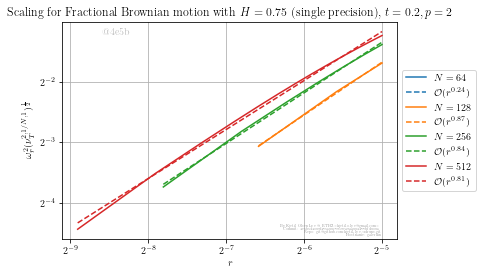

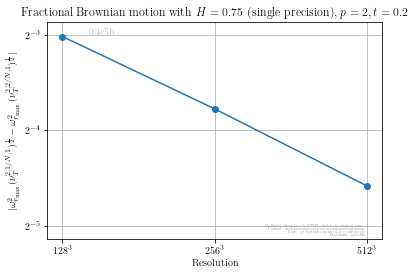

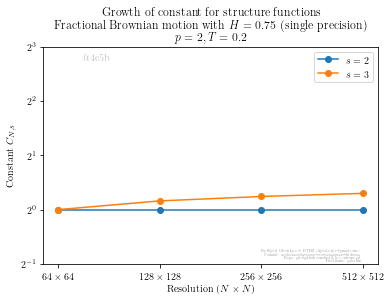

64
structure["Scaling for Fractional Brownian motion with $H=0.75$ (single precision), $t=0.2,p=3$"][64] = array([0.        , 0.20745822])
128
structure["Scaling for Fractional Brownian motion with $H=0.75$ (single precision), $t=0.2,p=3$"][128] = array([0.        , 0.13283707, 0.2317334 , 0.31508013])
256
structure["Scaling for Fractional Brownian motion with $H=0.75$ (single precision), $t=0.2,p=3$"][256] = array([0.        , 0.08364073, 0.14727135, 0.20245134, 0.25280888,
       0.29906997, 0.34168671, 0.3810837 ])
512
structure["Scaling for Fractional Brownian motion with $H=0.75$ (single precision), $t=0.2,p=3$"][512] = array([0.        , 0.05177145, 0.09168856, 0.12694889, 0.15978007,
       0.19055304, 0.21944139, 0.24660227, 0.27219689, 0.29638431,
       0.31931346, 0.34111842, 0.36191693, 0.38181105, 0.4008888 ,
       0.41922607])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


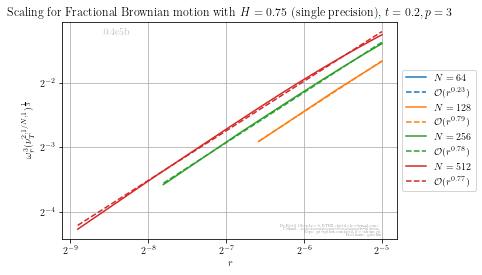

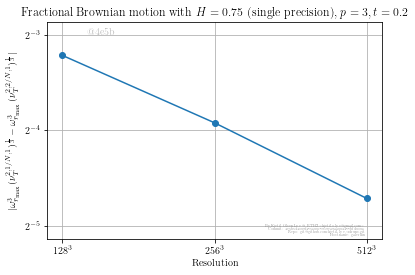

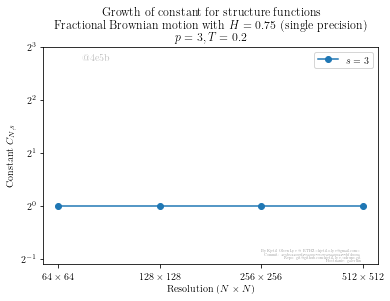

64
structure["Scaling for Fractional Brownian motion with $H=0.1$ (single precision), $t=0.2,p=1$"][64] = array([0.        , 1.59023013])
128
structure["Scaling for Fractional Brownian motion with $H=0.1$ (single precision), $t=0.2,p=1$"][128] = array([0.        , 1.26635628, 2.74032918, 3.86291338])
256
structure["Scaling for Fractional Brownian motion with $H=0.1$ (single precision), $t=0.2,p=1$"][256] = array([0.        , 0.99760945, 2.18475807, 3.11883596, 3.88407447,
       4.52126613, 5.05861969, 5.51749773])
512
structure["Scaling for Fractional Brownian motion with $H=0.1$ (single precision), $t=0.2,p=1$"][512] = array([0.        , 0.78347581, 1.727957  , 2.48553373, 3.11855768,
       3.65533331, 4.11526323, 4.51340575, 4.86164749, 5.16934508,
       5.44384621, 5.69092711, 5.91514662, 6.12012413, 6.30875368,
       6.48336746])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


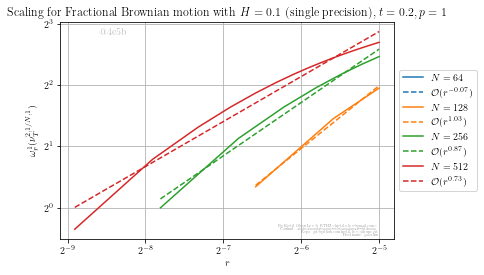

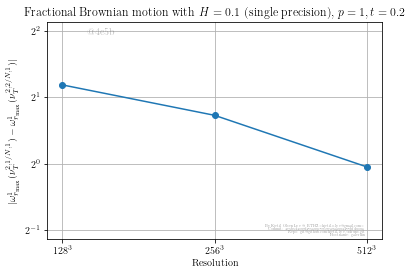

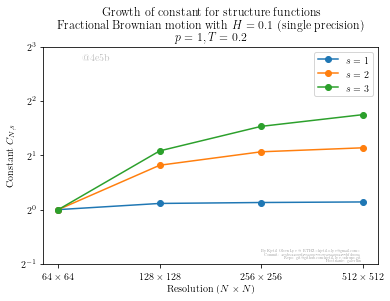

64
structure["Scaling for Fractional Brownian motion with $H=0.1$ (single precision), $t=0.2,p=2$"][64] = array([0.        , 1.56756521])
128
structure["Scaling for Fractional Brownian motion with $H=0.1$ (single precision), $t=0.2,p=2$"][128] = array([0.        , 1.29181148, 2.2798095 , 2.9873988 ])
256
structure["Scaling for Fractional Brownian motion with $H=0.1$ (single precision), $t=0.2,p=2$"][256] = array([0.        , 1.0468345 , 1.87003762, 2.48087574, 2.96631544,
       3.36193338, 3.69072973, 3.96885899])
512
structure["Scaling for Fractional Brownian motion with $H=0.1$ (single precision), $t=0.2,p=2$"][512] = array([0.        , 0.83710606, 1.50767163, 2.01689215, 2.43024901,
       2.77332468, 3.06288335, 3.31104557, 3.52674333, 3.71662091,
       3.88567156, 4.03769174, 4.17560381, 4.30168543, 4.41773349,
       4.52518243])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


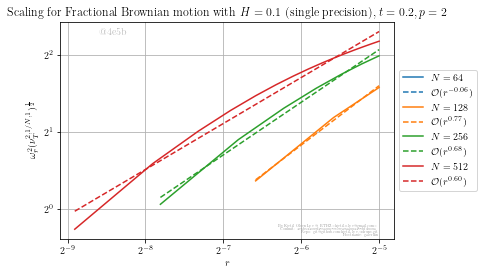

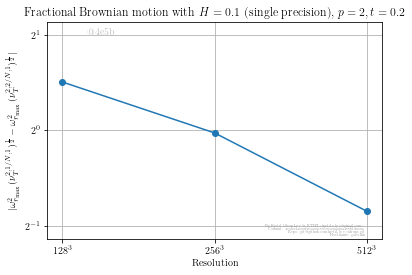

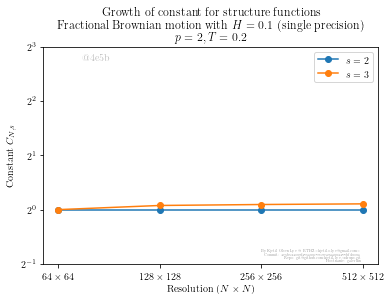

64
structure["Scaling for Fractional Brownian motion with $H=0.1$ (single precision), $t=0.2,p=3$"][64] = array([0.        , 1.98039902])
128
structure["Scaling for Fractional Brownian motion with $H=0.1$ (single precision), $t=0.2,p=3$"][128] = array([0.        , 1.70361454, 2.74347766, 3.45929472])
256
structure["Scaling for Fractional Brownian motion with $H=0.1$ (single precision), $t=0.2,p=3$"][256] = array([0.        , 1.44313082, 2.34337924, 2.98173411, 3.47402168,
       3.86765841, 4.1911174 , 4.46295201])
512
structure["Scaling for Fractional Brownian motion with $H=0.1$ (single precision), $t=0.2,p=3$"][512] = array([0.        , 1.20174125, 1.9612774 , 2.5100443 , 2.94094967,
       3.29101566, 3.58265257, 3.83070651, 4.04539655, 4.23395852,
       4.40164419, 4.55235089, 4.68902902, 4.81395243, 4.92890228,
       5.03529474])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


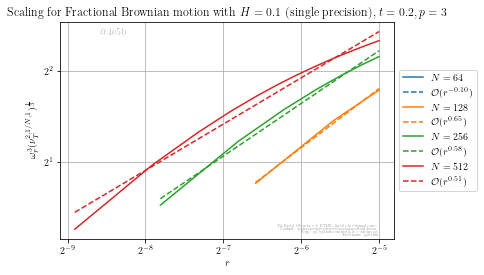

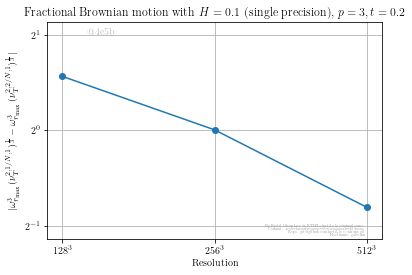

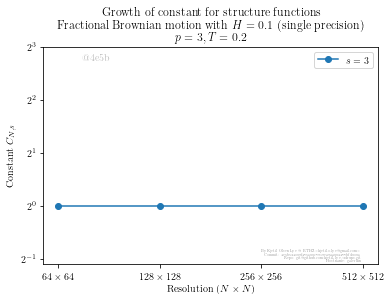

64
structure["Scaling for Richtmeyer-Meshkov $\epsilon=0.05$, $t=4,p=1$"][64] = array([0.        , 0.05906456])
128
structure["Scaling for Richtmeyer-Meshkov $\epsilon=0.05$, $t=4,p=1$"][128] = array([0.        , 0.04208282, 0.09574127, 0.14123475])
256
structure["Scaling for Richtmeyer-Meshkov $\epsilon=0.05$, $t=4,p=1$"][256] = array([0.        , 0.02841628, 0.06459832, 0.09542377, 0.12299178,
       0.14806437, 0.17105397, 0.19224845])
512
structure["Scaling for Richtmeyer-Meshkov $\epsilon=0.05$, $t=4,p=1$"][512] = array([0.        , 0.02075812, 0.0470392 , 0.06926789, 0.08895761,
       0.10669709, 0.12283746, 0.13763337, 0.15128309, 0.16394613,
       0.17575352, 0.18681449, 0.19722112, 0.20705165, 0.21637298,
       0.22524253])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


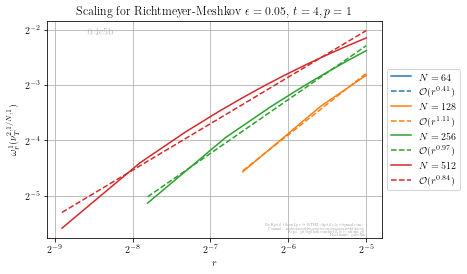

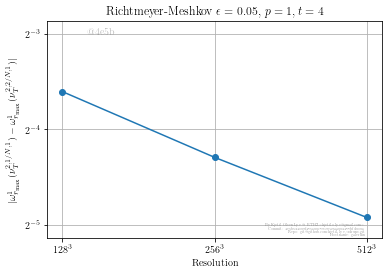

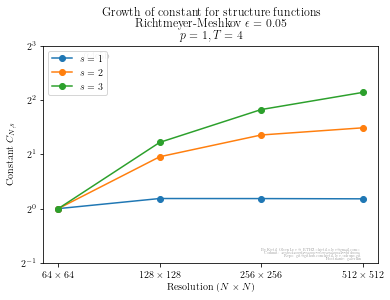

64
structure["Scaling for Richtmeyer-Meshkov $\epsilon=0.05$, $t=4,p=2$"][64] = array([0.       , 0.0785097])
128
structure["Scaling for Richtmeyer-Meshkov $\epsilon=0.05$, $t=4,p=2$"][128] = array([0.        , 0.07081746, 0.12868411, 0.17372921])
256
structure["Scaling for Richtmeyer-Meshkov $\epsilon=0.05$, $t=4,p=2$"][256] = array([0.        , 0.05236016, 0.09503898, 0.12825929, 0.15612793,
       0.18011947, 0.20109462, 0.21963733])
512
structure["Scaling for Richtmeyer-Meshkov $\epsilon=0.05$, $t=4,p=2$"][512] = array([0.        , 0.0425013 , 0.07678276, 0.10282126, 0.12397032,
       0.1415962 , 0.15658864, 0.16957255, 0.18099405, 0.1911761 ,
       0.20035687, 0.20871588, 0.21639145, 0.22349236, 0.23010557,
       0.23630153])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


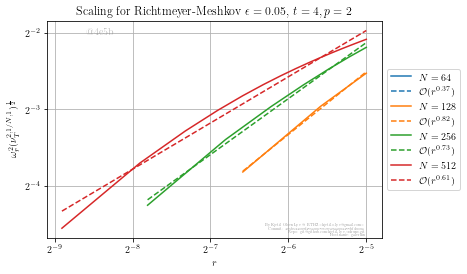

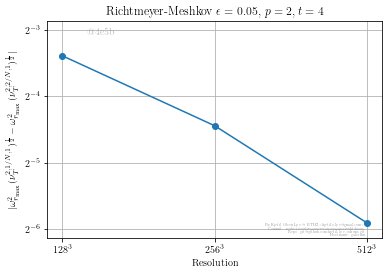

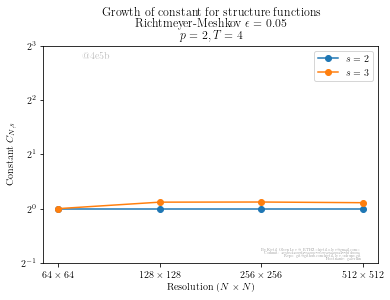

64
structure["Scaling for Richtmeyer-Meshkov $\epsilon=0.05$, $t=4,p=3$"][64] = array([0.       , 0.1171804])
128
structure["Scaling for Richtmeyer-Meshkov $\epsilon=0.05$, $t=4,p=3$"][128] = array([0.        , 0.12186365, 0.20180213, 0.26079654])
256
structure["Scaling for Richtmeyer-Meshkov $\epsilon=0.05$, $t=4,p=3$"][256] = array([0.        , 0.09728237, 0.16025477, 0.20627463, 0.24284061,
       0.27291006, 0.29818395, 0.31975441])
512
structure["Scaling for Richtmeyer-Meshkov $\epsilon=0.05$, $t=4,p=3$"][512] = array([0.        , 0.07932807, 0.13037466, 0.16678989, 0.19466472,
       0.21671809, 0.23467083, 0.24965869, 0.26244364, 0.27354752,
       0.28333693, 0.29207682, 0.29996415, 0.30714911, 0.31374865,
       0.31985543])


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:66: RankWarning: Polyfit may be poorly conditioned


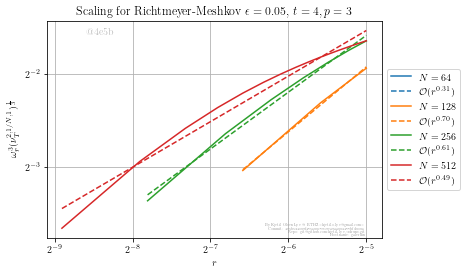

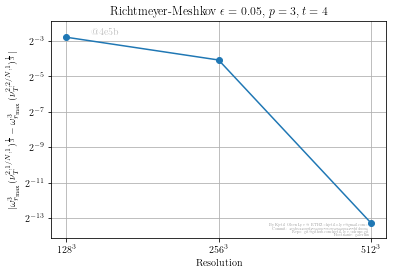

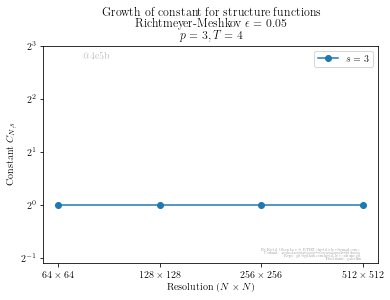

In [4]:
def convergence_structure_functions(config):
    headline("Component convergence Box averaged structure functions")
    variables = ['rho', 'mx','my','mz', 'E']
    perturbations = config['perturbations']
    Tarray = config['Tarray']
    resolutions = config['resolutions']
    cube_filename = config['cube_filename']
    name = config['name']
    maxT = config['maxT']
    for perturbation in perturbations:
        h2("perturbation = %.2f" % perturbation)
        for p in [1,2,3]:
            h3("p = %d" % p)
            timeArray = Tarray
                
            for t in timeArray:
                h4("t = %d" % (0.2*t))

                errors = zeros(len(resolutions)-1)

                constants_from_theorem_mean = collections.defaultdict(list)
                for (nr, resolution) in enumerate(resolutions):
                    if 'new_pert' not in cube_filename:
                        resolution_structure = resolution
                    else:
                        resolution_structure = 512
                        
                    dVar = zeros(int(resolution_structure*32/1024))
                    print(resolution_structure)
                    
                            
                    for variable in variables:
                       
                        if '{perturbation_dot_replaced}' in cube_filename:
                            perturbation_str = str(perturbation).replace('.', '_')
                            cube_filename_local = cube_filename.replace('{perturbation_dot_replaced}', '{perturbation}')
                        else:
                            perturbation_str = str(perturbation)
                            cube_filename_local = cube_filename
                            
                        filename = cube_filename_local.format(perturbation = perturbation_str, p=p,t=t,
                                                        resolution=resolution)

                        d = getlineintegral(filename, variable, resolution=resolution_structure)


                        dVar += d
                    dVar = dVar**(1.0/p)
                    if resolution > resolutions[0]:
                        errors[nr-1] = abs(dVar[-1]-dPrev[-1])
                        
                    if resolution != resolution_structure:
                        dPrev = dVar
                    else:
                        dPrev = repeat(dVar,2,0)
                    
                    t_start = config.get("t_start", 0.0)
                    time = t_start
                    if max(timeArray) > 0:
                        time += t * maxT / max(timeArray)
                    if len(perturbations) > 1:
                        title = f'Scaling for {name}, $t={time},p={p},\\varepsilon={perturbation}$'
                    else:
                        title = f'Scaling for {name}, $t={time},p={p}$'

                    plotscalings(dVar, resolution, title, False)
                    plt.xlabel('$r$')
                    structure_power=''
                    if p != 1:
                        structure_power=f'^{{\\frac{{1}}{{{p}}}}}'
                    M = get_number_of_samples(filename)
                    
                    plt.ylabel(f'$\\omega^{{{p}}}_{{r}}(\\nu^{{2, 1/N,{M}}}_T){structure_power}$')
                        
                        
                    Ls = np.arange(0, dVar.shape[0])
                    for s in [1,2,3]:
                        if s < p:
                            continue
                        constant_per_l = dVar[1:]**(1.0/p) /(dVar[1]**(1.0/p) * Ls[1:]**(1.0/s))
                        constant = np.max(constant_per_l)
                        constants_from_theorem_mean[s].append(constant)
                        
                        
                        
                for nr in range(len(resolutions)-1):
                    errors[nr] = abs(errors[nr])

                showAndSave('scaling_{name}_{p}_{perturbation}_{time}'.format(name=name.replace('$','').replace(' ',"_").replace('=',''), p=p, perturbation=perturbation, time=t))
                plt.loglog(resolutions[1:],errors,'-o',label='%s' % variable, basex=2, basey=2)
                
                plt.ylim([2.0**(np.floor(np.log2(min(errors))))/1.1, 1.1*2.0**(np.ceil(np.log2(max(errors))))])
                if len(perturbations)>1:
                    title = f'{name}, $p={p}, t={time}, \\varepsilon={perturbation}$'
                else:
                    title = f'{name}, $p={p}, t={time}$'

                #plt.title('{name}, $p={p}, t={t}, \\varepsilon={perturbation}$'.format(name=name, perturbation=perturbation, p=p,t=t*maxT/float(max(Tarray))))

                plt.title(title)
                plt.xlabel('Resolution $N^3$')
                plt.ylabel(f'$|\\omega^{{{p}}}_{{r_{{\\mathrm{{max}}}}}}(\\nu^{{2, 1/N,{M}}}_T){structure_power}-\\omega^{{{p}}}_{{r_{{\\mathrm{{max}}}}}}(\\nu^{{2, 2/N,{M}}}_T){structure_power}|$')
                plt.grid('on')
                plt.xticks(resolutions[1:], ['${r}^3$'.format(r=r) for r in resolutions[1:]])
                showAndSave('convergence_{name}_{p}_{perturbation}_{time}'.format(name=name.replace('$','').replace(' ',"_").replace('=',''), p=p, perturbation=perturbation, time=t))
                
                
                for s in constants_from_theorem_mean.keys():
                    plt.loglog(resolutions, constants_from_theorem_mean[s], '-o',
                             label=f'$s={s}$')
                
                
               
                plt.legend()
                plt.xscale('log', basex=2)
                plt.yscale('log', basey=2)
                plt.xlabel('Resolution ($N^3$)')
                plt.ylabel('Constant $C_{N,s}$')
                plt.title(f"Growth of constant for structure functions\n{name}\n$p={p}, T={time}$")
                plt.xticks(resolutions, [f'${N}^3$' for N in resolutions])
                ylims = plt.gca().get_ylim()
                plt.ylim([min(0.5, ylims[0]), max(8, ylims[1])])
                plot_info.showAndSave(f'structure_constant_theorem_{name}_{p}_{perturbation}_{time}')
                
                plt.close('all')
                
for_each_config(convergence_structure_functions)